In [94]:
# !pip install ray[tune]
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from hyperopt import hp
from ray import tune
from hyperopt import fmin, tpe, hp,Trials, space_eval
import scipy.stats

In [22]:
df = pd.read_csv("../../Data/Raw/flightLogData.csv")

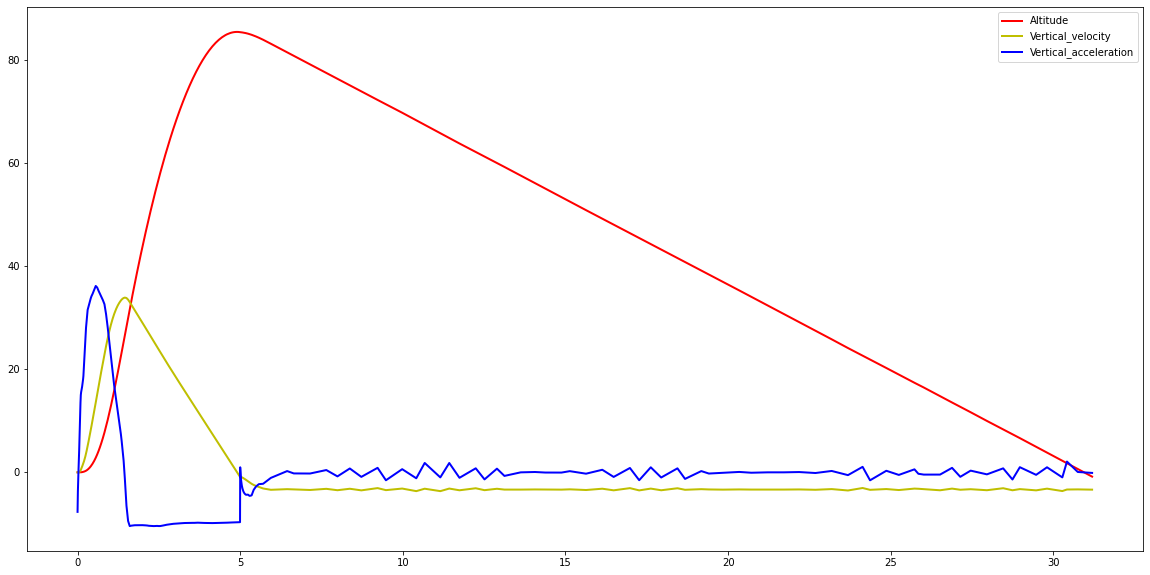

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(df.Time, df['Altitude'],  linewidth=2, color="r", label="Altitude")
plt.plot(df.Time, df['Vertical_velocity'],  linewidth=2, color="y", label="Vertical_velocity")
plt.plot(df.Time, df['Vertical_acceleration'],  linewidth=2, color="b", label="Vertical_acceleration")
plt.legend()
plt.show()

In [24]:
temp_df = df[['Altitude', "Vertical_velocity", "Vertical_acceleration"]]
noise = np.random.normal(2, 5, temp_df.shape)
noisy_df = temp_df + noise
noisy_df['Time'] = df['Time']


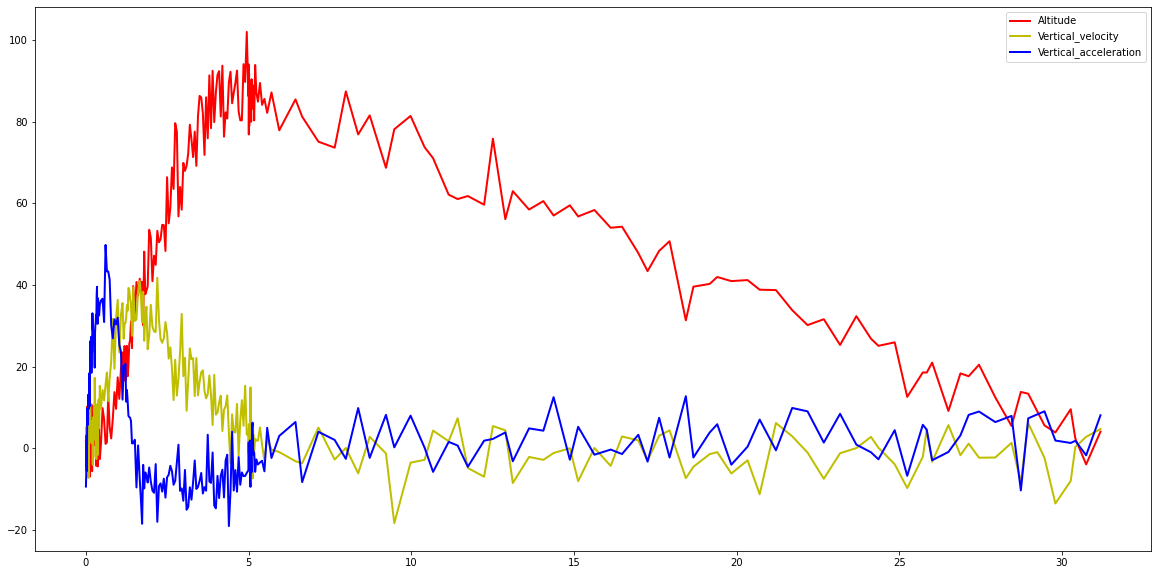

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(noisy_df.Time, noisy_df['Altitude'],  linewidth=2, color="r", label="Altitude")
plt.plot(noisy_df.Time, noisy_df['Vertical_velocity'],  linewidth=2, color="y", label="Vertical_velocity")
plt.plot(noisy_df.Time, noisy_df['Vertical_acceleration'],  linewidth=2, color="b", label="Vertical_acceleration")
plt.legend()
plt.show()

In [26]:
q = 0.001
A = np.array([[1.0, 0.1, 0.005], [0, 1.0, 0.1], [0, 0, 1]])
H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
# R = np.array([[0.5, 0.0], [0.0, 0.0012]])
# Q = np.array([[q, 0.0, 0.0], [0.0, q, 0.0], [0.0, 0.0, q]])
I = np.identity(3)
x_hat = np.array([[0.0], [0.0], [0.0]])
Y = np.array([[0.0], [0.0]])

In [69]:
def kalman_update(param):
    r1, r2, q1 = param['r1'], param['r2'], param['q1']
    R = np.array([[r1, 0.0], [0.0, r2]])
    Q = np.array([[q1, 0.0, 0.0], [0.0, q1, 0.0], [0.0, 0.0, q1]])
    
    A = np.array([[1.0, 0.1, 0.005], [0, 1.0, 0.1], [0, 0, 1]])
    H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    I = np.identity(3)
    x_hat = np.array([[0.0], [0.0], [0.0]])
    Y = np.array([[0.0], [0.0]])

    new_altitude = []
    new_acceleration = []
    new_velocity = []
    
    for altitude, az in zip(noisy_df['Altitude'], noisy_df['Vertical_acceleration']):
        Z = np.array([[altitude], [az]])

        x_hat_minus = np.dot(A, x_hat)
        P_minus = np.dot(np.dot(A, P), np.transpose(A)) + Q
        K  = np.dot(np.dot(P_minus, np.transpose(H)), np.linalg.inv((np.dot(np.dot(H, P_minus), np.transpose(H)) + R)))
        Y = Z - np.dot(H, x_hat_minus)
        x_hat = x_hat_minus + np.dot(K, Y)
        P = np.dot((I - np.dot(K, H)), P_minus)
        Y = Z - np.dot(H, x_hat_minus)
        new_altitude.append(float(x_hat[0]))
        new_velocity.append(float(x_hat[1]))
        new_acceleration.append(float(x_hat[2]))
    return new_altitude

In [123]:
def objective_function(param):
    r1, r2, q1 = param['r1'], param['r2'], param['q1']
    R = np.array([[r1, 0.0], [0.0, r2]])
    Q = np.array([[q1, 0.0, 0.0], [0.0, q1, 0.0], [0.0, 0.0, q1]])
    
    A = np.array([[1.0, 0.1, 0.005], [0, 1.0, 0.1], [0, 0, 1]])
    H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    I = np.identity(3)
    x_hat = np.array([[0.0], [0.0], [0.0]])
    Y = np.array([[0.0], [0.0]])

    new_altitude = []
    new_acceleration = []
    new_velocity = []
    
    for altitude, az in zip(noisy_df['Altitude'], noisy_df['Vertical_acceleration']):
        Z = np.array([[altitude], [az]])

        x_hat_minus = np.dot(A, x_hat)
        P_minus = np.dot(np.dot(A, P), np.transpose(A)) + Q
        K  = np.dot(np.dot(P_minus, np.transpose(H)), np.linalg.inv((np.dot(np.dot(H, P_minus), np.transpose(H)) + R)))
        Y = Z - np.dot(H, x_hat_minus)
        x_hat = x_hat_minus + np.dot(K, Y)
        P = np.dot((I - np.dot(K, H)), P_minus)
        Y = Z - np.dot(H, x_hat_minus)
        new_altitude.append(float(x_hat[0]))
        new_velocity.append(float(x_hat[1]))
        new_acceleration.append(float(x_hat[2]))
    return 1 - scipy.stats.pearsonr(x=df['Altitude'], y=new_altitude)[0]

In [158]:
space = {
    "r1": hp.choice("r1", np.arange(0.1, 0.9, 0.005)),
    "r2": hp.choice("r2", np.arange(0.1, 0.9, 0.005)),
    "q1": hp.choice("q1", np.arange(0.1, 0.9, 0.0001))
}

In [159]:
# Initialize trials object
trials = Trials()

best = fmin(fn=objective_function, space = space, algo=tpe.suggest, max_evals=100, trials=trials )

100%|█████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/trial, best loss: 0.00447847612158403]


In [160]:
print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

{'q1': 262, 'r1': 105, 'r2': 114}
{'q1': 0.12620000000000076, 'r1': 0.6250000000000004, 'r2': 0.6700000000000005}


In [161]:
d1 = space_eval(space, best)

In [162]:
objective_function(d1)

0.00447847612158403

In [163]:
objective_function({'q1': 0.0013, 'r1': 0.25, 'r2': 0.65})

0.009736938785821936

In [164]:
y = kalman_update(d1)
current = kalman_update({'q1': 0.0013, 'r1': 0.25, 'r2': 0.65})

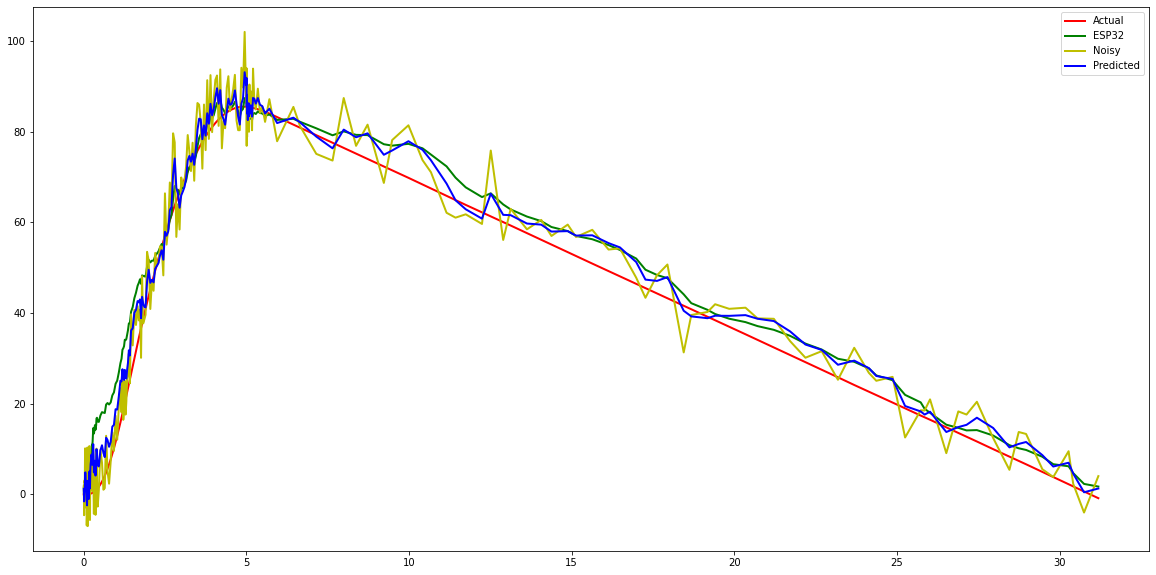

In [165]:
plt.figure(figsize=(20, 10))
plt.plot(noisy_df.Time, df['Altitude'],  linewidth=2, color="r", label="Actual")
plt.plot(noisy_df.Time, current,  linewidth=2, color="g", label="ESP32")
plt.plot(noisy_df.Time, noisy_df['Altitude'],  linewidth=2, color="y", label="Noisy")
plt.plot(noisy_df.Time, y,  linewidth=2, color="b", label="Predicted")
plt.legend()
plt.show()